# Shelter Animal Outcomes

**Дано:** данные о кошках и собаках, поступивших в приют

**Найти:** что с ними станет? Возьмут в приют / вернётся хозяин / ...

In [2]:
import numpy as np
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")

#### Загружаем датасет

In [4]:
data = pd.read_csv('Shelter.csv')

и смотрим на это

In [5]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## все фичи надо обрабатывать

In [6]:
X = data.drop(['AnimalID', 'OutcomeType', 'OutcomeSubtype'], axis=1)
X.index = range(len(X))
X.columns = X.columns.str.lower()
data_columns = X.columns

In [7]:
X.head()

,name,datetime,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [8]:
X.shape

(26729, 7)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            19038 non-null  object
 1   datetime        26729 non-null  object
 2   animaltype      26729 non-null  object
 3   sexuponoutcome  26728 non-null  object
 4   ageuponoutcome  26711 non-null  object
 5   breed           26729 non-null  object
 6   color           26729 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


Также нам необходимо закодировать значения целевой переменной

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
le = LabelEncoder()
y = le.fit_transform(data.OutcomeType)

In [12]:
data.SexuponOutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [13]:
y

array([3, 2, 0, ..., 0, 4, 4])

# Готовим фичи

будем в конце датафрейма наращивать числовые фичи, не удаляя оригинальные: вдруг пригодится :))

**имя** превращаем в:
* наличие имени
* длину имени
* частоту имени

In [14]:
# наличие имени
X['has_name'] = X.name.isnull().astype(int)

# длина имени
X['name_len'] = X.name.str.len()
X.name_len.fillna(X.name_len.median(), inplace=True)

# количество слов в имени
X['name_words_num'] = X.name.str.split().str.len()
X.name_words_num.fillna(X.name_words_num.median(), inplace=True)

# частота встречаемости имени
names_freq = X.name.value_counts().to_dict()
X['name_freq'] = X.name.apply(lambda x: names_freq.get(x))
X.name_freq.fillna(X.name_freq.median(), inplace=True)

#### Даты: переводим строки в даты

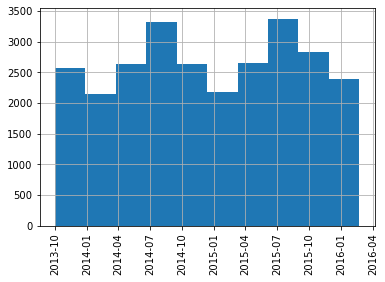

In [15]:
X.datetime = pd.to_datetime(X.datetime)
X.datetime.hist(xrot=90);

In [16]:
X['year'] = X.datetime.apply(lambda x: x.year)
X['month'] = X.datetime.apply(lambda x: x.month)
X['day'] = X.datetime.apply(lambda x: x.day)
X['hour'] = X.datetime.apply(lambda x: x.hour + x.minute/60)
X['weekday'] = X.datetime.apply(lambda x: x.weekday())

#### С видом животного проще

In [17]:
X.animaltype.value_counts()

Dog    15595
Cat    11134
Name: animaltype, dtype: int64

In [18]:
X['is_dog'] = (X.animaltype=='Dog').astype(int)

#### С полом сложнее. Делим на две фичи
* Neutered, Spayed - стерилизованные
* Intact - нетронутые

In [19]:
X.sexuponoutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: sexuponoutcome, dtype: int64

In [20]:
X.sexuponoutcome.fillna('Unknown', inplace=True)

In [21]:
X['sterilization'] = X.sexuponoutcome.apply(lambda x: x.split()[0])
X.sterilization = X.sterilization.replace({'Neutered': 'Sterilized', 'Spayed': 'Sterilized'})

In [22]:
X['sex'] = X.sexuponoutcome.apply(lambda x: x.split()[-1])

In [23]:
X['sex'].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [24]:
le_sterilization = LabelEncoder()
le_sex = LabelEncoder()

In [25]:
X.sterilization = le_sterilization.fit_transform(X.sterilization)
X.sex = le_sex.fit_transform(X.sex)

#### Приведем возраст к единому значению

In [26]:
X.ageuponoutcome.value_counts()[:30]

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
7 months      288
9 years       288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
Name: ageuponoutcome, dtype: int64

In [27]:
X.ageuponoutcome.str.split().str[1].value_counts()

years     10874
months     8339
year       3969
weeks      1704
month      1281
days        332
week        146
day          66
Name: ageuponoutcome, dtype: int64

In [28]:
X.ageuponoutcome.str.split().str[1].str.rstrip('s').value_counts()

year     14843
month     9620
week      1850
day        398
Name: ageuponoutcome, dtype: int64

In [29]:
t_dig = X.ageuponoutcome.str.split().str[0].fillna(0).astype(int)
t_int = X.ageuponoutcome.str.split().str[1].str.rstrip('s').replace({'year': 365, 'month': 365/12, 'week':7, 'day':1}).fillna(0)

In [30]:
X["years"] = t_dig*t_int/365

порода достаточно разнообразна и содержит в себе также  поле "Mix" и короткошёрстность животного

In [31]:
X.breed.value_counts()[:10]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: breed, dtype: int64

Поступим просто: соединим все описания в один большой текст и посчитаем в нём вхождение каждого слова. Флаги наличия самых популярных и включим как фичи

In [32]:
from collections import Counter

In [33]:
one_big_text = " ".join(X.breed)
words = one_big_text.replace('/',' / ').split()
most_common = Counter(words).most_common()
most_common[:20]

[('Mix', 22298),
 ('Shorthair', 11413),
 ('Domestic', 10403),
 ('/', 3068),
 ('Chihuahua', 2591),
 ('Retriever', 2460),
 ('Bull', 2445),
 ('Pit', 2395),
 ('Labrador', 2275),
 ('Terrier', 1673),
 ('Shepherd', 1398),
 ('Australian', 1049),
 ('German', 995),
 ('Hair', 908),
 ('Medium', 884),
 ('Miniature', 815),
 ('Longhair', 797),
 ('Dachshund', 788),
 ('Dog', 711),
 ('Cattle', 640)]

Можно было бы просто вставить флаги вхождения первых, скажем, 4 слов. Но давайте посмотрим, а насколько они важны? Составим матрицу, состоящую только из вхождения первых N слов, обучим на них дерево и проверим важность фичей

In [34]:
Xbreed = pd.DataFrame()
for col, num in most_common[:10]:
    Xbreed[col] = X.breed.str.contains(col).astype(int)

In [35]:
Xbreed

,Mix,Shorthair,Domestic,/,Chihuahua,Retriever,Bull,Pit,Labrador,Terrier
0,1,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0
3,1,1,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
26724,1,1,1,0,0,0,0,0,0,0
26725,1,1,1,0,0,0,0,0,0,0
26726,1,0,0,0,0,0,1,0,0,0
26727,1,1,1,0,0,0,0,0,0,0


In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
clf = DecisionTreeClassifier(max_depth=4)

In [38]:
clf.fit(Xbreed, data.OutcomeType)

DecisionTreeClassifier(max_depth=4)

In [39]:
clf.feature_importances_

array([0.03160924, 0.02125524, 0.82691139, 0.0446535 , 0.        ,
       0.        , 0.0701799 , 0.00539074, 0.        , 0.        ])

In [40]:
Xbreed.columns

Index(['Mix', 'Shorthair', 'Domestic', '/', 'Chihuahua', 'Retriever', 'Bull',
       'Pit', 'Labrador', 'Terrier'],
      dtype='object')

В принципе, оказалось, что влияет по большей части только **Domestic**. Но включим сюда на всякий случай ещё один признак

In [41]:
X['is_domestic'] = X.breed.str.contains('Domestic').astype(int)
X['is_Bull'] = X.breed.str.contains('Bull').astype(int)

#### Остался цвет. Выглядит похоже на проблему породы, повторим те же операции

Здесь важность менее сосредоточена, возьмём первые 5 фичей. Самая важная, Tabby - это полосатость

In [42]:
X.color.value_counts()

Black/White                2824
Black                      2292
Brown Tabby                1635
Brown Tabby/White           940
White                       931
                           ... 
Tortie Point/Lynx Point       1
Gold/Black                    1
Orange/Tan                    1
Silver Tabby/Black            1
Yellow/Black                  1
Name: color, Length: 366, dtype: int64

In [43]:
one_big_text = " ".join(X.color)
words = one_big_text.replace('/',' / ').split()
most_common = Counter(words).most_common()
most_common[:20]

[('/', 13924),
 ('White', 12198),
 ('Black', 8038),
 ('Brown', 6699),
 ('Tabby', 5191),
 ('Tan', 3031),
 ('Blue', 2358),
 ('Orange', 1440),
 ('Brindle', 1021),
 ('Red', 991),
 ('Tricolor', 912),
 ('Tortie', 618),
 ('Cream', 612),
 ('Point', 588),
 ('Calico', 583),
 ('Chocolate', 519),
 ('Gray', 407),
 ('Torbie', 398),
 ('Buff', 328),
 ('Merle', 325)]

In [44]:
Xcolor = pd.DataFrame()
for col, num in most_common[:10]:
    Xcolor[col] = X.color.str.contains(col).astype(int)

In [45]:
clf.fit(Xcolor, y)

DecisionTreeClassifier(max_depth=4)

In [46]:
clf.feature_importances_

array([0.13222148, 0.09588076, 0.0702783 , 0.06136179, 0.63291544,
       0.00164846, 0.        , 0.        , 0.00569378, 0.        ])

In [47]:
Xcolor.columns

Index(['/', 'White', 'Black', 'Brown', 'Tabby', 'Tan', 'Blue', 'Orange',
       'Brindle', 'Red'],
      dtype='object')

#### Осталось проверить итоговую таблицу на пропуски

In [48]:
X.isnull().sum()

name              7691
datetime             0
animaltype           0
sexuponoutcome       0
ageuponoutcome      18
breed                0
color                0
has_name             0
name_len             0
name_words_num       0
name_freq            0
year                 0
month                0
day                  0
hour                 0
weekday              0
is_dog               0
sterilization        0
sex                  0
years                0
is_domestic          0
is_Bull              0
dtype: int64

In [49]:
X = X.drop(data_columns.str.lower(), axis=1)
X

,has_name,name_len,name_words_num,name_freq,year,month,day,hour,weekday,is_dog,sterilization,sex,years,is_domestic,is_Bull
0,0,7.0,1.0,5.0,2014,2,12,18.366667,2,1,1,1,1.000000,0,0
1,0,5.0,1.0,16.0,2013,10,13,12.733333,6,0,1,0,1.000000,1,0
2,0,6.0,1.0,2.0,2015,1,31,12.466667,5,1,1,1,2.000000,0,1
3,1,5.0,1.0,6.0,2014,7,11,19.150000,4,0,0,1,0.057534,1,0
4,1,5.0,1.0,6.0,2013,11,15,12.866667,4,1,1,1,2.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,1,5.0,1.0,6.0,2015,5,14,11.933333,3,0,0,1,0.083333,1,0
26725,1,5.0,1.0,6.0,2016,1,20,18.983333,2,0,1,0,0.250000,1,0
26726,0,4.0,1.0,36.0,2015,3,9,13.550000,0,1,1,1,4.000000,0,1
26727,1,5.0,1.0,6.0,2014,4,27,12.366667,6,0,0,1,0.076712,1,0


In [50]:
X.isnull().sum()

has_name          0
name_len          0
name_words_num    0
name_freq         0
year              0
month             0
day               0
hour              0
weekday           0
is_dog            0
sterilization     0
sex               0
years             0
is_domestic       0
is_Bull           0
dtype: int64

In [51]:
X.shape

(26729, 15)

In [52]:
y.shape

(26729,)

### Задание 1

У нас есть X и y. Делим на обучающую и тестовую выборку

1. Обучить решающее дерево и подобрать наилучшие гиперпараметры дерева.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
depths = np.arange(1,20)
#features_num = np.arange(5,20)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, cv=5, n_jobs=-1, verbose=1)

In [57]:
%%time
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s


Wall time: 5.9 s


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    5.7s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             verbose=1)

In [60]:
gridsearch.cv_results_

{'mean_fit_time': array([0.02360129, 0.04220233, 0.05260301, 0.06000333, 0.06280365,
        0.08280482, 0.08920512, 0.09240537, 0.10120583, 0.11400647,
        0.13740802, 0.12580729, 0.13320765, 0.13880796, 0.15060868,
        0.16320939, 0.15640888, 0.15700898, 0.14160819]),
 'std_fit_time': array([0.00671158, 0.01585522, 0.01341116, 0.01962771, 0.00828055,
        0.01672704, 0.01349737, 0.01121846, 0.01264034, 0.01715904,
        0.02019619, 0.01090749, 0.01569037, 0.01182266, 0.0132159 ,
        0.01463506, 0.01121842, 0.01519301, 0.00781324]),
 'mean_score_time': array([0.00440025, 0.00660043, 0.00540047, 0.00560031, 0.00540028,
        0.00460024, 0.00800042, 0.00520015, 0.00800037, 0.00600033,
        0.00520015, 0.00480018, 0.00500031, 0.00480022, 0.00560026,
        0.00460024, 0.00480027, 0.00520034, 0.00480018]),
 'std_score_time': array([0.00048978, 0.00520024, 0.00135643, 0.00101992, 0.00080009,
        0.00048994, 0.00509934, 0.00116618, 0.00517711, 0.00252985,
        

In [68]:
gridsearch.cv_results_['mean_test_score']

array([0.56989162, 0.60627568, 0.60721104, 0.60997032, 0.62283113,
       0.64219183, 0.65813945, 0.66426596, 0.6661365 , 0.66328418,
       0.66131965, 0.6536032 , 0.64845928, 0.640696  , 0.63340055,
       0.62792891, 0.62624552, 0.61843515, 0.61792097])

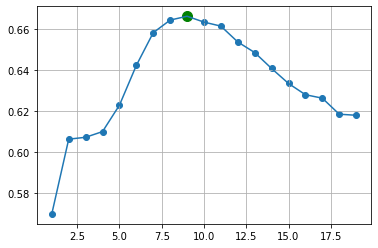

In [69]:
# визуализация поиска лучшего параметра max_depth 
scores = [x.mean() for x in gridsearch.cv_results_['mean_test_score']]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmax(scores)
plt.grid()
plt.scatter(depths[best_point], scores[best_point], c='g', s=100);

Так, отлично, спасли себя от переобучения (правда, в Grid можно было указать и другие параметры и найти более оптимальную точку).  
ЧТО И БУДЕМ ЗАДАНИЕМ!! :))

Фиксируем полученный полученные лучшие параметры

In [71]:
clf_final = DecisionTreeClassifier(max_depth=9)

In [72]:
clf_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

Делаем предсказания

In [73]:
y_pred_proba = clf_final.predict_proba(X_test)
y_pred = clf_final.predict(X_test)

#### Метрика качества

In [74]:
from sklearn.metrics import classification_report

In [75]:
report = classification_report(y_test, y_pred, target_names=data.OutcomeType.unique())
print(report)

                 precision    recall  f1-score   support

Return_to_owner       0.70      0.82      0.75      2219
     Euthanasia       0.33      0.12      0.18        33
       Adoption       0.54      0.18      0.28       298
       Transfer       0.47      0.46      0.46       961
           Died       0.75      0.68      0.71      1835

       accuracy                           0.67      5346
      macro avg       0.56      0.45      0.48      5346
   weighted avg       0.66      0.67      0.66      5346



Визуализация дерева

In [ ]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

http://www.webgraphviz.com

In [ ]:
#get_tree_dot_view(clf_final, list(Xtrain_prep.columns), list(le.classes_))

### ЗАДАНИЕ 2

1. Построить модель логистической регрессии с наилучшим качеством.

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [77]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [78]:
X_sdt = scaler.transform(X)
X_sdt = pd.DataFrame(X_sdt, columns=X.columns)
X_sdt

,has_name,name_len,name_words_num,name_freq,year,month,day,hour,weekday,is_dog,sterilization,sex,years,is_domestic,is_Bull
0,-0.635595,1.107036,-0.176138,-0.396611,-0.580974,-1.409043,-0.421688,1.020412,-0.540755,0.844954,0.440451,0.736846,-0.396515,-0.798188,-0.333063
1,-0.635595,-0.291256,-0.176138,0.116771,-1.929785,0.879415,-0.307667,-0.640992,1.414315,-1.183497,0.440451,-1.015860,-0.396515,1.252838,-0.333063
2,-0.635595,0.407890,-0.176138,-0.536624,0.767836,-1.695100,1.744707,-0.719638,0.925548,0.844954,0.440451,0.736846,-0.059276,-0.798188,3.002434
3,1.573328,-0.291256,-0.176138,-0.349940,-0.580974,0.021244,-0.535709,1.251436,0.436780,-1.183497,-1.540837,0.736846,-0.714351,1.252838,-0.333063
4,1.573328,-0.291256,-0.176138,-0.349940,-1.929785,1.165473,-0.079626,-0.601669,0.436780,0.844954,0.440451,0.736846,-0.059276,-0.798188,-0.333063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,1.573328,-0.291256,-0.176138,-0.349940,0.767836,-0.550871,-0.193646,-0.876931,-0.051987,-1.183497,-1.540837,0.736846,-0.705650,1.252838,-0.333063
26725,1.573328,-0.291256,-0.176138,-0.349940,2.116647,-1.695100,0.490478,1.202282,-0.540755,-1.183497,0.440451,-1.015860,-0.649444,1.252838,-0.333063
26726,-0.635595,-0.990403,-0.176138,1.050194,0.767836,-1.122985,-0.763750,-0.400138,-1.518290,0.844954,0.440451,0.736846,0.615202,-0.798188,3.002434
26727,1.573328,-0.291256,-0.176138,-0.349940,-0.580974,-0.836928,1.288624,-0.749131,1.414315,-1.183497,-1.540837,0.736846,-0.707883,1.252838,-0.333063


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_sdt, y, test_size=0.2, random_state=42)

In [80]:
grid = {'C': [0.01, 0.1, 1], 
       'penalty':['l1', 'l2'],
       'tol':[0.001, 0.0001, 0.00001],
       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
gridsearch = GridSearchCV(LogisticRegression(), grid, cv=5, n_jobs=-1, verbose=1)

In [81]:
%%time
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.6min finished


Wall time: 1min 37s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.001, 0.0001, 1e-05]},
             verbose=1)

In [82]:
gridsearch.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}

In [83]:
model = LogisticRegression(C=0.1, penalty = 'l1',tol=0.001, solver='saga')

In [84]:
# обучаем модель
model.fit(X_train, y_train)
Log_pred_proba = model.predict_proba(X_test )
Log_pred = model.predict(X_test)

In [85]:
report_2 = classification_report(y_test, Log_pred, target_names=data.OutcomeType.unique())
print(report_2)

                 precision    recall  f1-score   support

Return_to_owner       0.61      0.76      0.68      2219
     Euthanasia       0.00      0.00      0.00        33
       Adoption       0.59      0.10      0.17       298
       Transfer       0.48      0.33      0.39       961
           Died       0.62      0.63      0.63      1835

       accuracy                           0.60      5346
      macro avg       0.46      0.37      0.37      5346
   weighted avg       0.59      0.60      0.58      5346



### Также [можно](http://scikit-learn.org/stable/modules/model_persistence.html) сохранять и модели:


In [ ]:
import joblib

In [ ]:
joblib.dump(clf, 'data/shelter/clf_decisiontree_maxdepth_9.pkl')